In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)

import pandas as pd
import numpy as np
import tflscripts
import json
import pickle
from tflscripts import boxplot_by, scatter_plot_by, heatmap_by
import matplotlib.patches as mpatches

configuration = tflscripts.read_configuration()
df = pd.read_pickle('results.p')

In [3]:
df['type_of_transfer'] = df.type_of_transfer.map({
    'Same device type in same place': 'B: replaced device',
    'Same device type in different place': 'C: different placement',
    'Same device in different place': 'C: different placement',
    'Same device type across spaces': 'D: different room',
    'Same device across spaces': 'D: different room',
    'Different device in same place': 'E: different sensor board',
    'Same device in same place': '__remove__',
    'Different device in different place': '__remove__',
    'Different device across spaces': '__remove__',
    'No transfer': 'A: before transfer'
})

df = df.loc[df.type_of_transfer != '__remove__']

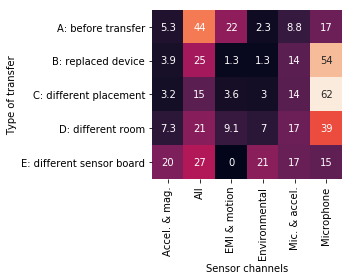

In [21]:
import seaborn
plt.rcParams["figure.figsize"] = (5, 4)

def rename_features(df):
    df = df.copy()
    df['features_name'] = df['features_name'].map({
        'All': 'All',
        'Microphone': 'Microphone',
        'Microphone & accelerometer': 'Mic. & accel.',
        'Environmental': 'Environmental',
        'EMI & motion': 'EMI & motion',
        'Accelerometer & magnetometer': 'Accel. & mag.',
    })
    return df

only_best = df
only_best = only_best.sort_values(by='f1', ascending=False)
only_best = only_best.drop_duplicates(['source_dataset', 'target_dataset', 'source_device', 'target_device', 'label'], keep='first')
only_best = only_best.loc[((only_best.source_device_type == 'Mite') & (only_best.target_device_type == 'Mite')) | (only_best.source_device_type != only_best.target_device_type)]

_df = rename_features(only_best)
_df = _df.groupby(['features_name', 'type_of_transfer']).size()
_df = _df.reset_index()
_df = _df.pivot_table(index='features_name', columns='type_of_transfer', values=0)
_df = _df / _df.sum()
# _df = _df.loc[_df.index != 'All']
_df = _df.fillna(0)
_df *= 100
seaborn.heatmap(_df.T, annot=True, cbar=None)
plt.ylabel('Type of transfer')
plt.xlabel('Sensor channels')
plt.tight_layout()

plt.savefig('../plots/heatmap_features_for_transfer_type.pdf')
plt.show()

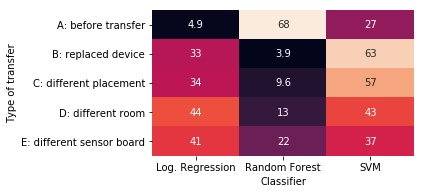

In [26]:
import seaborn
plt.rcParams["figure.figsize"] = (6, 2.8)

def rename_classifier(df):
    df = df.copy()
    df['classifier'] = df['classifier'].map({
        'LogisticRegression': 'Log. Regression',
        'RandomForestClassifier': 'Random Forest',
        'SVM': 'SVM'
    })
    return df


only_best = df
only_best = only_best.sort_values(by='f1', ascending=False)
only_best = only_best.drop_duplicates(['source_dataset', 'target_dataset', 'source_device', 'target_device', 'label'], keep='first')

_df = rename_classifier(only_best)
_df = _df.groupby(['classifier', 'type_of_transfer']).size()
_df = _df.reset_index()
_df = _df.pivot_table(index='classifier', columns='type_of_transfer', values=0)
_df = _df / _df.sum()
# _df = _df.loc[_df.index != 'All']
_df = _df.fillna(0)
_df *= 100
seaborn.heatmap(_df.T, annot=True, cbar=None)
plt.ylabel('Type of transfer')
plt.xlabel('Classifier')

plt.tight_layout()

plt.savefig('../plots/heatmap_classifier_performance_by_transfer.pdf')
plt.show()

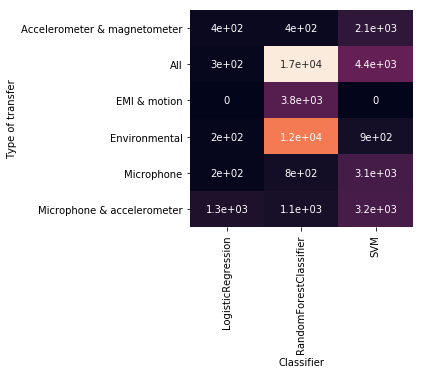

In [47]:
import seaborn

only_best = df
only_best = only_best.sort_values(by='f1', ascending=False)
only_best = only_best.drop_duplicates(['source_dataset', 'target_dataset', 'source_device', 'target_device', 'label'], keep='first')
only_best = only_best.loc[only_best.type_of_transfer == 'A: before transfer']

_df = only_best.groupby(['classifier', 'features_name']).size()
_df = _df.reset_index()
_df = _df.pivot_table(index='classifier', columns='features_name', values=0)
# _df = _df / _df.sum()
# _df = _df.loc[_df.index != 'All']
_df = _df.fillna(0)
_df *= 100
seaborn.heatmap(_df.T, annot=True, cbar=None)
plt.ylabel('Type of transfer')
plt.xlabel('Classifier')

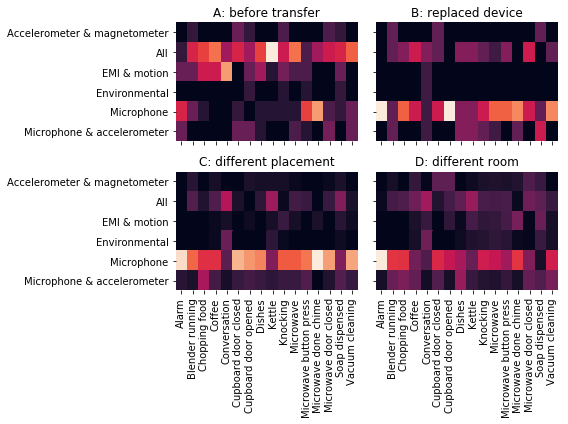

In [11]:
import seaborn
plt.rcParams["figure.figsize"] = (8, 6)


def label_features_heatmap(type_of_transfer, ax):
    only_best = df
    only_best = only_best.sort_values(by='f1', ascending=False)
    only_best = only_best.drop_duplicates(['source_dataset', 'target_dataset', 'source_device', 'target_device', 'label'], keep='first')
    only_best = only_best.loc[only_best.type_of_transfer == type_of_transfer]
    only_best = only_best.loc[only_best.source_device_type == 'Mite']

    _df = only_best.groupby(['label', 'features_name']).size()
    _df = _df.reset_index()
    _df = _df.pivot_table(index='label', columns='features_name', values=0)

    # _df = _df.loc[_df.index != 'All']
    _df = _df.fillna(0)
    _df *= 100
    _df = _df.T
    _df = _df / _df.sum()
    seaborn.heatmap(_df, cbar=None, ax=ax)
    matplotlib.pyplot.sca(ax)
    plt.title(type_of_transfer)
    
    plt.ylabel('')
    plt.xlabel('')

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
label_features_heatmap('A: before transfer', axes[0][0])
label_features_heatmap('B: replaced device', axes[0][1])
label_features_heatmap('C: different placement', axes[1][0])
label_features_heatmap('D: different room', axes[1][1])
plt.tight_layout()

plt.savefig('../plots/heatmap_features_by_activities.pdf')
plt.show()

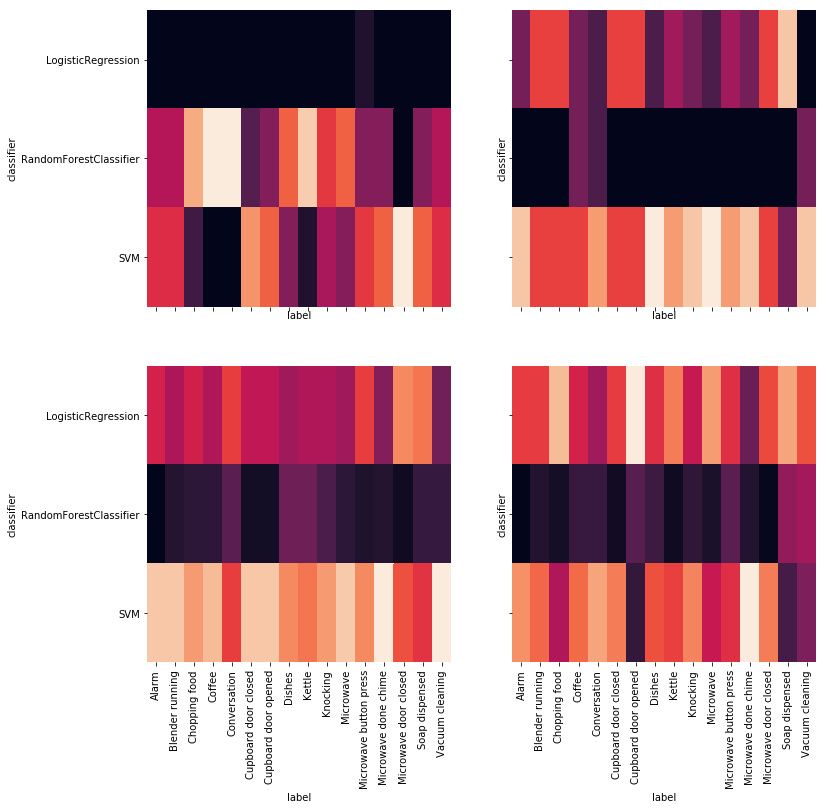

In [75]:
import seaborn
plt.rcParams["figure.figsize"] = (12, 12)


def label_classifier_heatmap(type_of_transfer, ax):
    only_best = df
    only_best = only_best.sort_values(by='f1', ascending=False)
    only_best = only_best.drop_duplicates(['source_dataset', 'target_dataset', 'source_device', 'target_device', 'label'], keep='first')
    only_best = only_best.loc[only_best.type_of_transfer == type_of_transfer]
    only_best = only_best.loc[only_best.source_device_type == 'Mite']

    _df = only_best.groupby(['label', 'classifier']).size()
    _df = _df.reset_index()
    _df = _df.pivot_table(index='label', columns='classifier', values=0)

    # _df = _df.loc[_df.index != 'All']
    _df = _df.fillna(0)
    _df *= 100
    _df = _df.T
    _df = _df / _df.sum()
    seaborn.heatmap(_df, cbar=None, ax=ax)
#     plt.ylabel('Type of transfer')
#     plt.xlabel('Classifier')

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
label_classifier_heatmap('A: before transfer', axes[0][0])
label_classifier_heatmap('B: replaced device', axes[0][1])
label_classifier_heatmap('C: different placement', axes[1][0])
label_classifier_heatmap('D: different room', axes[1][1])